In [175]:
import os
import imageio
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from SlicingDataLoading import DataLoad
from audio_resnet_encoder_wavenet_decoder import Encoder
from audio_resnet_encoder_wavenet_decoder import Decoder
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import random

In [177]:
# CHANGE THE ENCODER PATH
ENCODER_PATH = 'audio_cvae_encoder_20250501_000037_with_wavenet.pth'
DECODER_PATH = 'audio_cvae_decoder_20250501_000037_with_wavenet.pth'

# CHANGE THE PATH IF DATA CHANGE
DATASET_PATH = "./Data/genres_original"

# KEEP THE LATENT SPACE SIZE THE SAME UNLESS MODEL ARCH CHENGES
LATENT_SPACE_SIZE = 1024

# CHOOSE THE GENRE YOU ARE INTERESTED IN
class1 = "rock"
class2 = "classical"

classes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [179]:
def prepare_data(DATASET_PATH):
    data_loader = DataLoad(DATASET_PATH)
    X, y = data_loader.fetch_dataset()
    return X, y

In [193]:
def load_model(encoder_path, decoder_path):
    encoder = Encoder(LATENT_SPACE_SIZE)
    encoder.load_state_dict(torch.load(encoder_path))
    encoder.eval()

    decoder = Decoder(LATENT_SPACE_SIZE)
    decoder.load_state_dict(torch.load(decoder_path))
    decoder.eval()
    return encoder, decoder

In [195]:
def encode_audio(encoder, audio):
    with torch.no_grad():
        audio_tensor = torch.from_numpy(audio)
        audio_tensor = audio_tensor.unsqueeze(1)  
        
        # Audio data typically has shape [batch, channels, time] or [batch, time, channels]
        # If needed, you might need to permute dimensions, e.g.:
        # audio_tensor = audio_tensor.permute(0, 2, 1)  # if input is [batch, time, channels]
        
        mu, logvar, z = encoder(audio_tensor)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        return z.numpy()

In [197]:
def AttributeShift(encoder_model, decoder_model, data1, data2, factor = 1):
    latent_codes_data1 = encode_audio(encoder_model, data1)
    latent_codes_data2 = encode_audio(encoder_model, data2)
    mean_code_data1 = np.mean(latent_codes_data1, axis=0)
    mean_code_data2 = np.mean(latent_codes_data2, axis=0)
    attribute_shift_vector = mean_code_data1 - mean_code_data2
    shifted_codes = latent_codes_data2 + factor * attribute_shift_vector
    print(shifted_codes.shape)
    shifted_codes = torch.from_numpy(shifted_codes).float()
    print(shifted_codes.shape)
    with torch.no_grad():
        audio_output = decoder_model(shifted_codes)
    print(audio_output.shape)
    return audio_output

In [199]:
def PlotAudioTransfer(data, audio_output, sr=18000, show_spectrogram=True):
    if isinstance(audio_output, torch.Tensor):
        audio_output = audio_output.detach().cpu().numpy()
    if isinstance(data, torch.Tensor):
        data = data.detach().cpu().numpy()

    if len(data.shape) > 2:
        data = data.squeeze()
    if len(audio_output.shape) > 2:
        audio_output = audio_output.squeeze()

    num_samples = min(4, len(data))
    sample_index = random.sample(range(len(data)), num_samples)

    fig, axs = plt.subplots(num_samples, 2, figsize=(15, 3*num_samples))
    if num_samples == 1:
        axs = axs.reshape(1, -1)  

    for i, idx in enumerate(sample_index):
        original_audio = data[idx]
        transferred_audio = audio_output[idx]

        if show_spectrogram:
            axs[i, 0].specgram(original_audio, Fs=sr)
            axs[i, 0].set_title('Original Audio')
            axs[i, 0].set_ylabel('Frequency')
            
            axs[i, 1].specgram(transferred_audio, Fs=sr)
            axs[i, 1].set_title('Transferred Audio')
        else:
            # Plot waveforms
            axs[i, 0].plot(original_audio)
            axs[i, 0].set_title('Original Waveform')
            axs[i, 0].set_ylabel('Amplitude')
            
            axs[i, 1].plot(transferred_audio)
            axs[i, 1].set_title('Transferred Waveform')

    plt.tight_layout()
    plt.show()

    if num_samples > 0:
        import IPython.display as ipd
        print("Original audio:")
        ipd.display(ipd.Audio(data[sample_index[0]], rate=sr))
        print("Transferred audio:")
        ipd.display(ipd.Audio(audio_output[sample_index[0]], rate=sr))

(500, 1024)
torch.Size([500, 1024])
torch.Size([500, 1, 90000])


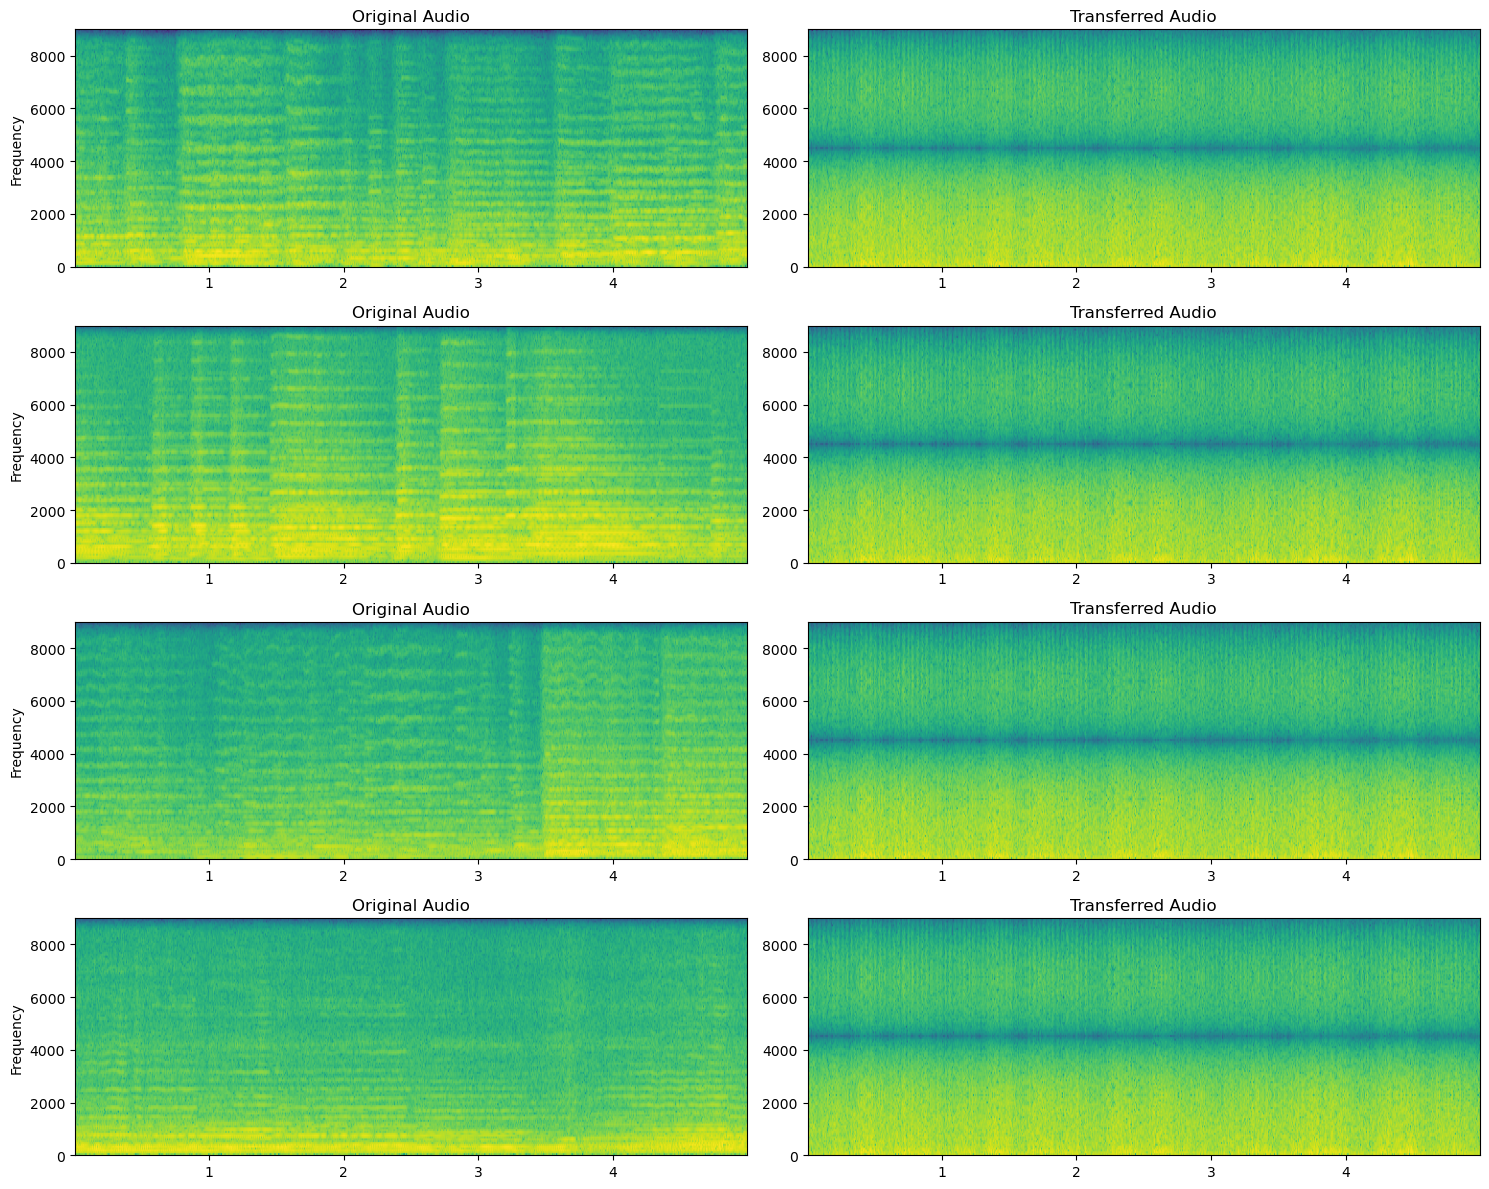

Original audio:


Transferred audio:


In [201]:
if __name__ == "__main__":
    all_photos, all_attrs = prepare_data(DATASET_PATH)
    encoder, decoder = load_model(ENCODER_PATH, DECODER_PATH)
    class1_index = classes.index(class1)
    class2_index = classes.index(class2)
    class1_idx = np.where(all_attrs == class1_index)
    class2_idx = np.where(all_attrs == class2_index)
    
    data1 = all_photos[class1_idx]
    data2 = all_photos[class2_idx]
    
    shifted_audios = AttributeShift(encoder, decoder, data1, data2)
    PlotAudioTransfer(data2, shifted_audios)